In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

In [2]:
# --- 1. Load and Merge Data ---

# Load data
train_transaction = pd.read_csv('C:/Users/Matúš/Desktop/Marekova praca/Prediction-of-Fraud-transactions/input/train_transaction.csv')
train_identity = pd.read_csv('C:/Users/Matúš/Desktop/Marekova praca/Prediction-of-Fraud-transactions/input/train_identity.csv')
# train_transaction = pd.read_csv('C:/Users/Marek/Desktop/2024-2025/Diplomová práca/Diplomová práca/Prediction-of-Fraud-transactions/input/train_transaction.csv')
# train_identity = pd.read_csv('C:/Users/Marek/Desktop/2024-2025/Diplomová práca/Diplomová práca/Prediction-of-Fraud-transactions/input/train_identity.csv')

# Merge datasets
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

# Simple target definition
# X_check = train_df.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
# y_check = train_df['isFraud']

In [3]:
# 1. Create a UID to track "users" across time
train_df['uid'] = train_df['card1'].astype(str)+'_'+train_df['card2'].astype(str)+'_'+train_df['addr1'].astype(str)

# 2. Transaction Amount relative to User Average
# Does this user usually spend $10 but is now spending $1000?
train_df['uid_Amt_mean'] = train_df.groupby(['uid'])['TransactionAmt'].transform('mean')
train_df['uid_Amt_std'] = train_df.groupby(['uid'])['TransactionAmt'].transform('std')
train_df['Amt_to_mean_ratio'] = train_df['TransactionAmt'] / train_df['uid_Amt_mean']

# 3. Time Engineering
# Fraud often peaks at 3 AM or on weekends.
train_df['hour'] = (train_df['TransactionDT'] // 3600) % 24
train_df['day_of_week'] = (train_df['TransactionDT'] // (3600 * 24)) % 7

# 2. Calculate Cutoff Points
n_total = len(train_df)
idx_train_end = int(n_total * 0.70)      # End of first 70%
idx_val_end   = int(n_total * 0.85)      # End of next 15% (70+15=85)

In [4]:
# 3. Slice the Dataframe
# .iloc works by position [start : end]
train_set = train_df.iloc[ :idx_train_end]              # 0% to 70%
val_set   = train_df.iloc[idx_train_end : idx_val_end]  # 70% to 85%
test_set  = train_df.iloc[idx_val_end: ]                # 85% to 100%

In [5]:
cols_to_drop = ['isFraud', 'TransactionID', 'TransactionDT']

# TRAIN
X_train = train_set.drop(cols_to_drop, axis=1)
y_train = train_set['isFraud']

# VALIDATION
X_val = val_set.drop(cols_to_drop, axis=1)
y_val = val_set['isFraud']

# TEST (The Hold-out)
X_test = test_set.drop(cols_to_drop, axis=1)
y_test = test_set['isFraud']

In [6]:
missing_threshold = 0.80

missing_series = X_train.isnull().mean()
drop_cols = missing_series[missing_series > missing_threshold].index
print(f"Dropping {len(drop_cols)} columns with > {missing_threshold:.0%} missing values.")

X_train_clean = X_train.drop(columns=drop_cols)
X_val_clean   = X_val.drop(columns=drop_cols)
X_test_clean  = X_test.drop(columns=drop_cols)

Dropping 74 columns with > 80% missing values.


In [7]:
X_xgb = X_train_clean.copy()

print("Encoding categorical columns for XGBoost...")
for col in X_xgb.select_dtypes(include=['object']).columns:
    X_xgb[col] = X_xgb[col].astype('category').cat.codes

# 2. Configure & Train XGBoost
# We use 'hist' tree method because it's extremely fast
clf = XGBClassifier(
    n_estimators=100,       # 100 trees is enough for feature selection
    max_depth=10,           # Deep trees to find complex fraud patterns
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    missing=np.nan,         # Critical: Tells XGBoost to handle NaNs automatically
    n_jobs=-1,              # Use all CPU cores
    random_state=42,
    tree_method='hist'      # Fast training mode
)

print("Training XGBoost to find the most important features...")
clf.fit(X_xgb, y_train)

Encoding categorical columns for XGBoost...
Training XGBoost to find the most important features...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

--- Top 100 Features Selected ---
['V258', 'C1', 'C14', 'card2', 'D2', 'C13', 'uid_Amt_std', 'uid', 'uid_Amt_mean', 'V317']


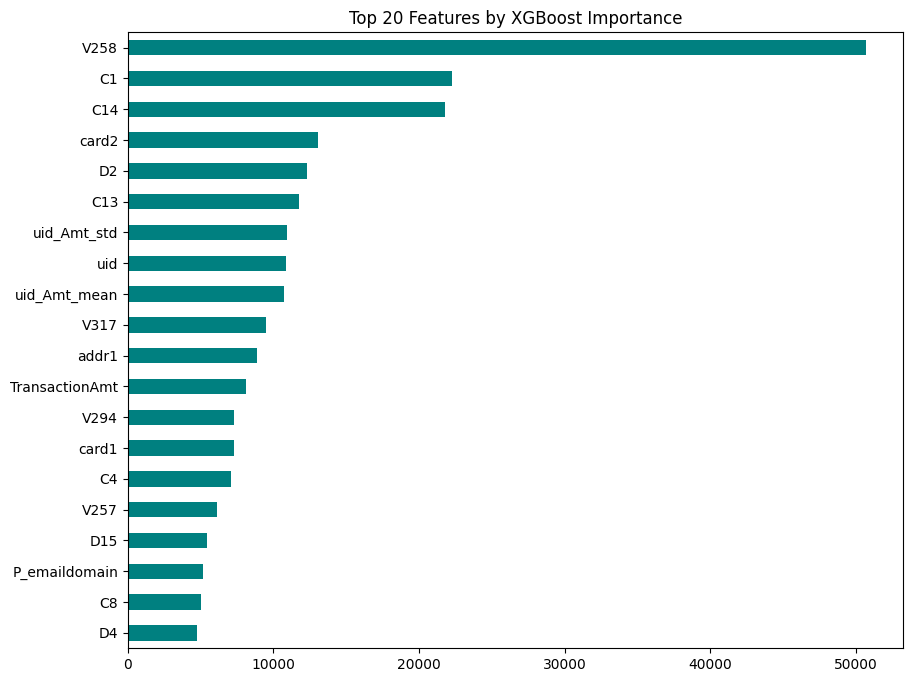

In [8]:
importances = pd.Series(clf.get_booster().get_score(importance_type='total_gain'))

# 2. Sort and Take Top 50
TOP_N = 100
best_features = importances.sort_values(ascending=False).head(TOP_N).index.tolist()

print(f"--- Top {TOP_N} Features Selected ---")
print(best_features[:10])  # Print top 10 to check

# 3. Visualize
plt.figure(figsize=(10, 8))
importances.sort_values(ascending=False).head(20).plot(kind='barh', color='teal')
plt.title('Top 20 Features by XGBoost Importance')
plt.gca().invert_yaxis() # Highest importance on top
plt.show()

In [9]:
FINAL_CAT_COLS = []
FINAL_NUM_COLS = []

print("classifying Top Features...")

for col in best_features:
    # A. Is it an Object (String) in the original cleaned data?
    if X_train_clean[col].dtype == 'object':
        FINAL_CAT_COLS.append(col)
        
    # B. Is it a Number but behaves like a Category? (Few unique values)
    # Example: 'card4' might be 1, 2, 3, 4. Treat as Category.
    elif X_train_clean[col].nunique() < 20:
        FINAL_CAT_COLS.append(col)
        
    # C. Otherwise, it is a Number (Amount, Time, Distance)
    else:
        FINAL_NUM_COLS.append(col)

print(f"--------------------------------")
print(f"Feature Split for Neural Network:")
print(f" - Categorical (Embeddings): {len(FINAL_CAT_COLS)}")
print(f" - Numerical (Scaled):       {len(FINAL_NUM_COLS)}")
print(f"--------------------------------")

# After you get best_features from XGBoost importance:
manual_features = ['Amt_to_mean_ratio', 'hour', 'day_of_week']

for feat in manual_features:
    if feat not in best_features:
        best_features.append(feat)

# Now run your loop that splits into FINAL_CAT_COLS and FINAL_NUM_COLS
# ... (your existing loop) ...

# Verify they are in the list:
print(f"Is uid_count in numerical list? {'uid_count' in FINAL_NUM_COLS}")

# Finalize the Datasets
# We now discard all other columns and keep only the winners
X_train_ready = X_train_clean[best_features].copy()
X_val_ready   = X_val_clean[best_features].copy()
X_test_ready  = X_test_clean[best_features].copy()

classifying Top Features...
--------------------------------
Feature Split for Neural Network:
 - Categorical (Embeddings): 29
 - Numerical (Scaled):       71
--------------------------------
Is uid_count in numerical list? False


In [ ]:

# 1. Setup copies
X_rf_train = X_train_ready.copy()
X_rf_val   = X_val_ready.copy()
X_rf_test  = X_test_ready.copy()

# 2. Encode Categoricals (Same logic as before)
for col in FINAL_CAT_COLS:
    temp_all = pd.concat([X_rf_train[col], X_rf_val[col], X_rf_test[col]])
    le = LabelEncoder()
    le.fit(temp_all.astype(str))
    X_rf_train[col] = le.transform(X_rf_train[col].astype(str))
    X_rf_val[col]   = le.transform(X_rf_val[col].astype(str))
    X_rf_test[col]  = le.transform(X_rf_test[col].astype(str))

# 3. FILL MISSING VALUES (Crucial for Random Forest)
# We fill with -999 or median. Median is usually safer for ROC-AUC.
imputer = SimpleImputer(strategy='median')
X_rf_train = imputer.fit_transform(X_rf_train)
X_rf_val   = imputer.transform(X_rf_val)
X_rf_test  = imputer.transform(X_rf_test)

print("✅ Data Ready for Random Forest (Missing values imputed with median).")

✅ Data Ready for Random Forest (Missing values imputed with median).


In [26]:
# 1. Setup copies
X_rf_train = X_train_ready.copy()
X_rf_val   = X_val_ready.copy()
X_rf_test  = X_test_ready.copy()

# 2. Encode Categoricals (Same logic as before)
for col in FINAL_CAT_COLS:
    temp_all = pd.concat([X_rf_train[col], X_rf_val[col], X_rf_test[col]])
    le = LabelEncoder()
    le.fit(temp_all.astype(str))
    X_rf_train[col] = le.transform(X_rf_train[col].astype(str))
    X_rf_val[col]   = le.transform(X_rf_val[col].astype(str))
    X_rf_test[col]  = le.transform(X_rf_test[col].astype(str))

# 3. FILL MISSING VALUES (Crucial for Random Forest)
# We fill with -999 or median. Median is usually safer for ROC-AUC.
imputer = SimpleImputer(strategy='median')
X_rf_train = imputer.fit_transform(X_rf_train)
X_rf_val   = imputer.transform(X_rf_val)
X_rf_test  = imputer.transform(X_rf_test)

print("✅ Data Ready for Random Forest (Missing values imputed with median).")

✅ Data Ready for Random Forest (Missing values imputed with median).


In [27]:
# 1. Initialize the model
# n_jobs=-1 uses all CPU cores. class_weight='balanced' handles fraud imbalance.
rf_clf = RandomForestClassifier(
    n_estimators=200,      # Number of trees
    max_depth=15,          # Limit depth to prevent massive overfitting
    min_samples_leaf=5,    # Minimum samples in a "leaf" to stay generalized
    max_features='sqrt',   # Number of features to consider at each split
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1,
    verbose=1              # Shows progress while building trees
)

print("🚀 Training Random Forest... (this may take a few minutes)")
rf_clf.fit(X_rf_train, y_train)

🚀 Training Random Forest... (this may take a few minutes)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   30.3s finished


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=5, n_estimators=200, n_jobs=-1,
                       random_state=42, verbose=1)

In [28]:
from sklearn.metrics import roc_auc_score

# 1. Predict probabilities
rf_preds = rf_clf.predict_proba(X_rf_test)[:, 1]

# 2. Score
rf_auc = roc_auc_score(y_test, rf_preds)

print(f"\n🏆 Random Forest FINAL TEST ROC-AUC: {rf_auc:.5f}")
print("------------------------------------------------")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.1s finished



🏆 Random Forest FINAL TEST ROC-AUC: 0.88199
------------------------------------------------


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
AFTER TUNING PARAMS 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Define the "Search Space"
param_dist = {
    'n_estimators': [200, 500],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# 2. Initialize the search
# We use n_iter=10 to try 10 random combinations
rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', n_jobs=-1),
    param_distributions=param_dist,
    n_iter=10, 
    scoring='roc_auc', 
    cv=3,      # 3-fold cross validation
    verbose=2, 
    random_state=42
)

# 3. Fit (Note: This might take a while because it trains 30 models total)
rf_search.fit(X_rf_train, y_train)

print(f"Best Parameters: {rf_search.best_params_}")
print(f"Best CV AUC: {rf_search.best_score_:.5f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  59.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  29.5s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  29.8s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  30.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  22.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estima

In [17]:
# 1. Initialize the model
# n_jobs=-1 uses all CPU cores. class_weight='balanced' handles fraud imbalance.
tuned_rf = RandomForestClassifier(
    n_estimators=1000,           # More trees = smoother AUC curve
    max_depth=rf_search.best_params_.get('max_depth', 20),
    max_features=rf_search.best_params_.get('max_features', 'sqrt'),
    min_samples_leaf=rf_search.best_params_.get('min_samples_leaf', 2),
    min_samples_split=rf_search.best_params_.get('min_samples_split', 5),
    class_weight='balanced_subsample', # Better for imbalanced fraud data
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train on the full training set
tuned_rf.fit(X_rf_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.4min finished


RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1000, n_jobs=-1,
                       random_state=42, verbose=1)

In [18]:
from sklearn.metrics import roc_auc_score

# 1. Predict probabilities
rf_preds = tuned_rf.predict_proba(X_rf_test)[:, 1]

# 2. Score
rf_auc = roc_auc_score(y_test, rf_preds)

print(f"\n🏆 Random Forest FINAL TEST ROC-AUC: {rf_auc:.5f}")
print("------------------------------------------------")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.2s



🏆 Random Forest FINAL TEST ROC-AUC: 0.90518
------------------------------------------------


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    1.6s finished


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
PROOFS THAT SCORE IS LEGITIMATE AND NOT CAUSED BY CHEATING
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

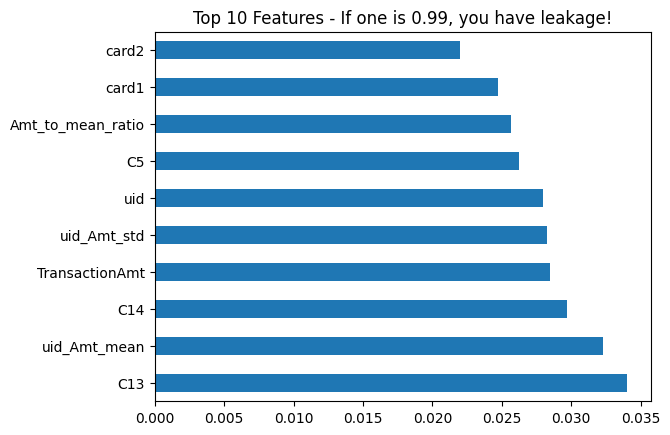

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Look at what the model prioritized
feat_importances = pd.Series(tuned_rf.feature_importances_, index=X_train_ready.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Features - If one is 0.99, you have leakage!")
plt.show()

In [23]:
# Check if 'isFraud' is in your features list
print("isFraud" in X_test_ready.columns) 

# Also print the count of columns - it should match your 'best_features' list
print(f"Number of columns in test: {len(X_test_ready.columns)}")

False
Number of columns in test: 100


In [25]:
# Select only numeric columns to avoid the String-to-Float error
numeric_cols = X_train_ready.select_dtypes(include=[np.number]).columns

# Run the correlation check only on those columns
correlations = X_train_ready[numeric_cols].corrwith(y_train)

print("Top 10 Features Correlated with Fraud:")
print(correlations.sort_values(ascending=False).head(10))

Top 10 Features Correlated with Fraud:
V257    0.370756
V201    0.327629
V189    0.301395
V45     0.277693
V258    0.263296
V87     0.246839
V38     0.188397
V80     0.173938
V262    0.154035
V78     0.152144
dtype: float64
